# Tara-Oceans ML Project
#### [By Joon Hwan Hong](https://github.com/Joon-Hwan-Hong "My Github Page!")

## Function:
1.	Read the Tara data from two files containing abundance and origin
2.	Visualize the Tara data in various ways
3.	Run and assess machine learning approaches to predict the abundance of certain bacteria, as a function of various physical and geographical parameters.
4.	Formulate a question you are interested in, write the code to address it, and summarize your result.

## Data:
1. miTAG.taxonomic.profiles.release.txt contains data about the abundance of different types of bacteria, archea, and protozoa in each sample.
2. sample_properties.txt contains information about the origin of each sample.

If there are any questions on the code, feel free to [email me](mailto:joon.hong@mail.mcgill.ca)
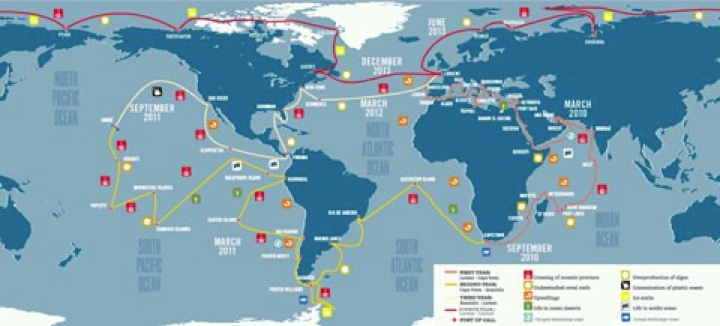

### Reading .txt files
Code to read in the Tara data from the two input files. Its purpose is to read the data to use it later.

In [1]:
# folium for displaying maps, pandas for dataframe, numpy for concatenating abundance from train & test data & random,
# matplotlib for displaying graphs, tree for decision tree regression, shuffle for randomization,
# mean_squared_error for determining mean squared error, train_test_split to split data collected for ML regression
import folium
import pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


def read_input_data(file1, file2, pos_other_specimen=12):
    datafile = open(file1, 'r')
    datafile2 = open(file2, 'r')
    datafile.readline()
    
    # miTag.txt read_file
    # generate list of TARA values that are present in miTag, datafile2.readline() reads the first line with all TARAs
    valid_TARA_list = datafile2.readline().split()[1:]
    # TEST: specific bacteria: AEGEAN-169_marine_group_AACY024102418.157.1623, and its abundance values
    line2, abundance = datafile2.readline(), []
    values_of_abundance = line2.split()[1:]
    # converts abundances to int() type
    for number in values_of_abundance:
        abundance.append(int(number))

    # sample_properties.txt readfile
    # read individual line, if read-line empty, break. otherwise append all values into respective data lists
    sample_TARA, date, lat, lon, sampling_depth, size_fraction, all_lat, all_lon = [], [], [], [], [], [], [], []
    while True:
        line = datafile.readline()
        if line == '':
            break
        values = line.split()
        
        # coordinate values for all latitudinal & longitudinal values
        all_lat.append(float(values[2]))
        all_lon.append(float(values[3]))
        
        # specific for all TARA values found in miTAG.intersect(sample.txt)
        if values[0] in valid_TARA_list:
            sample_TARA.append(values[0])
            date.append(values[1])
            lat.append(float(values[2]))
            lon.append(float(values[3]))
            sampling_depth.append(int(values[4]))
            size_fraction.append(float(values[5]))
            
    other_abundance = []
    for move_line in range(pos_other_specimen):
        datafile2.readline()
    other_data = datafile2.readline().split()
    other_Abundance = other_data[1:]
    # converts abundances to int() type, workaround.
    for number in other_Abundance:
        other_abundance.append(int(number))

    return sample_TARA, date, lat, lon, sampling_depth, size_fraction, abundance, all_lat, all_lon, other_abundance


sample_TARA, date, lat, lon, sampling_depth, size_fraction, abundance, all_lat, all_lon, other_abundance =\
    read_input_data(r'.\sample_properties.txt', r'.\miTAG.taxonomic.profiles.release.txt')


### Installation of mapping package:

I do not think the library used is part of the default libs in conda.
Installation: Run "conda install -c conda-forge folium".

Here is the [Full documentation.](http://python-visualization.github.io/folium/docs-v0.5.0/modules.html)

### Abundance of a chosen bacteria species:
Produces a world map showing the abundance of species Bacteria_Proteobacteria_Alphaproteobacteria_Rhodospirillales_Rhodospirillaceae_AEGEAN-
169_marine_group_AACY024102418.157.1623 for samples collected at depths of less than 10 meters.

>#### Installation of mapping package:
>I do not think the library used is part of the default libs in conda.
Installation: Run "conda install -c conda-forge folium".
>Here is the [Full documentation.](http://python-visualization.github.io/folium/docs-v0.5.0/modules.html)
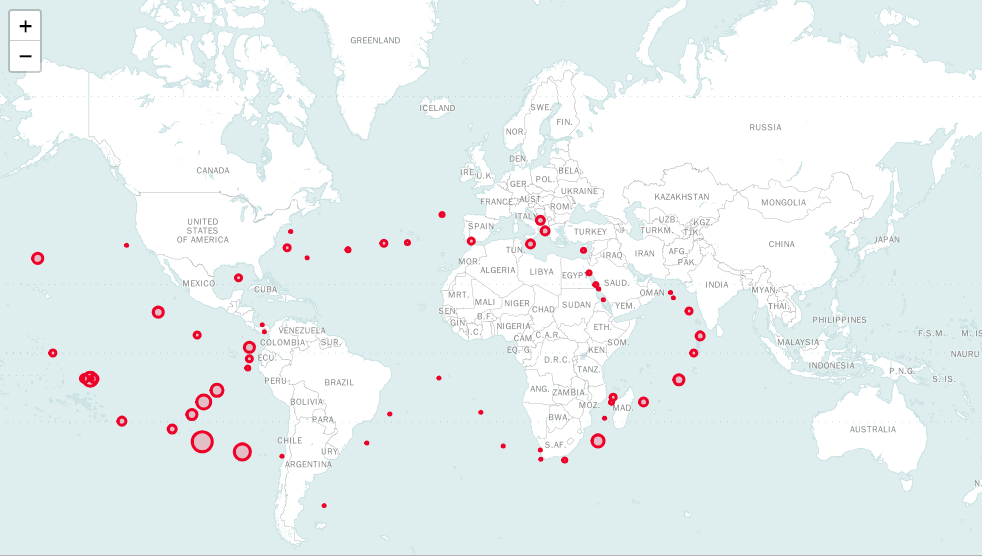

In [2]:
def abundance_plot(sample_TARA, date, lat, lon, sampling_depth, abundance):
    # create dataframe
    data = pandas.DataFrame({
        'TARA': sample_TARA,
        'date': date,
        'lat': lat,
        'lon': lon,
        'sampling_depth': sampling_depth,
        'abundance': abundance})

    # producing map and circles according to bacterial abundance & coordinates
    m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)
    for i in range(0, len(data)):
        if float(data.loc[i]['sampling_depth']) < 10:
            folium.Circle(
                location=[data.loc[i]['lat'], data.loc[i]['lon']],
                radius=int(data.loc[i]['abundance'])*100,
                color='crimson',
                fill=True,
                fill_color='crimson').add_to(m)

    return m


abundance_plot(sample_TARA, date, lat, lon, sampling_depth, abundance)

### Path of Data Collection:
Plot on the world map the path followed by the boat, based on the dates of the samples collected. 
The data on the .txt is already chronological
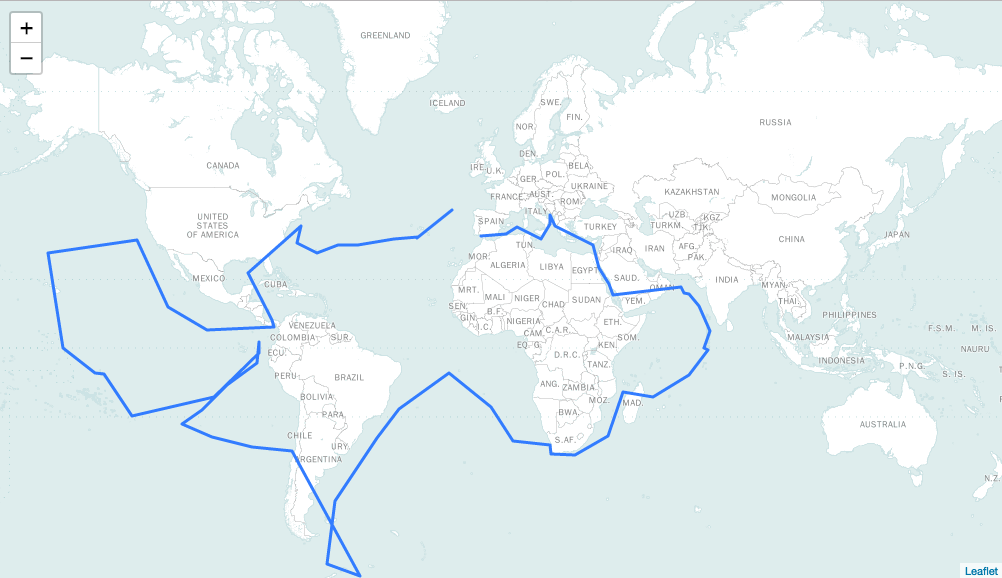

In [3]:
def boat_path(all_lat, all_lon):
    m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)
    locations = []
    allcoordinates = pandas.DataFrame({
        'lat': all_lat,
        'lon': all_lon})

    # create list of all coordinate positions
    for i in range(0, len(allcoordinates)):
        locations.append((allcoordinates.loc[i]['lat'], allcoordinates.loc[i]['lon']))

    # draw line
    folium.PolyLine(
        locations=locations).add_to(m)

    return m


boat_path(all_lat, all_lon)


### Random Forest Regressor:
Trains a random forest regressor that takes as input the latitude, longitude, depth, and size fraction to predict the abundance of Bacteria_Proteobacteria_Alphaproteobacteria_Rhodospirillales_Rhodospirillaceae_AEGEAN-169_marine_group_AACY024102418.157.1623 . 

#### Data Separation: 
Separates the set of samples randomly into 50% of the samples used for training, and 50% used for testing.

In [4]:
def split_data(lat, lon, sampling_depth, size_fraction, abundance):
    # data table creation, could probably use 'data' from before but creating separate dataframe for ensurance
    splitdataframe = pandas.DataFrame({
        'lat': lat,
        'lon': lon,
        'depth': sampling_depth,
        'size fraction': size_fraction,
        'abundance': abundance})

    # creates a training sample of 68 rows, as there are 135 TARA. 67 samples will be used for test
    X = splitdataframe.drop(['abundance'], axis=1).values
    Y = splitdataframe['abundance'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=67)

    return X_train, X_test, Y_train, Y_test


# make it into function because I may need it later for another part of task
X_train, X_test, Y_train, Y_test = split_data(lat, lon, sampling_depth, size_fraction, abundance)

#### Prediction Errors as a function of maximal depth:

Trains a decision tree regressor to predict the abundance of that bacteria from the four sample properties chosen.
For each maximum tree depth ranging from 1 to 10, a decision tree regressor is trained and evaluates its mean squared error on both the training set and the test set.
Plotted the training and testing errors obtained as a function of the maximal depth allowed.
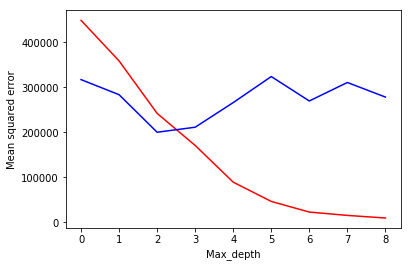

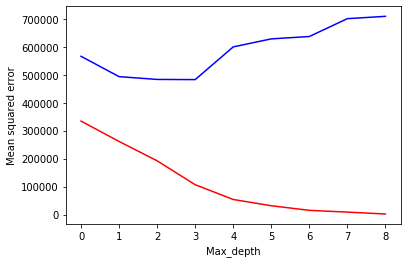

In [5]:
depth = range(9)
Mean_squared_error_train, Mean_squared_error_test, Max_depth_train, Max_depth_test = [], [], [], []

for counter in depth:
    model = tree.DecisionTreeRegressor(max_depth=counter + 1)
    model.fit(X_train, Y_train)

    # x values for plot
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    # y values for plot
    train_err = mean_squared_error(Y_train, pred_train)
    test_err = mean_squared_error(Y_test, pred_test)

    # append to lists for pyplot
    Max_depth_train.append(counter)
    Max_depth_test.append(counter)
    Mean_squared_error_train.append(train_err)
    Mean_squared_error_test.append(test_err)

plt.plot(Max_depth_train, Mean_squared_error_train, 'r')
plt.plot(Max_depth_test, Mean_squared_error_test, 'b')
plt.ylabel('Mean squared error'), plt.xlabel('Max_depth')

plt.show()


#### Visualize mis-prediction by ML model:
Visualize how the abundance of the selected species is mis-predicted by the decision tree with max_depth=2 (which is the one that produces the best prediction accuracy from experience). 
This cell generates a plot showing the observed vs predicted abundance values for the selected species, with one dot per sample.

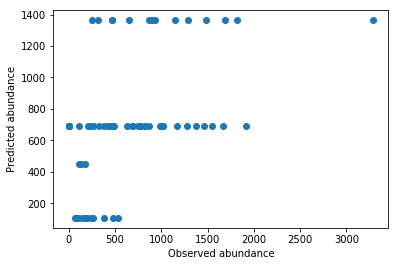

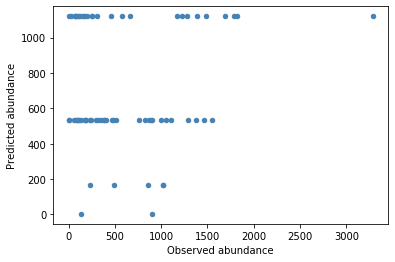

In [6]:
# train the virtual environment to model with depth of 2.
model = tree.DecisionTreeRegressor(max_depth=2)
model.fit(X_train, Y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# randomly sample abundance by creating dataframe of abundance then taking sample with length of the testing values
Abundance = pandas.DataFrame({'abundance': abundance})
random_abundance = Abundance['abundance'].sample(n=len(pred_test))

# data frame for graphing, x= randomly sampled abundance value, y= predicted abundance from test values. & graphing
data4 = pandas.DataFrame({
    'Observed abundance': random_abundance,
    'Predicted abundance': pred_test})

data4.plot(kind='scatter', x='Observed abundance', y='Predicted abundance', color='steelblue')
plt.show()


#### Plot the signed error
(Signed error == difference between predicted and observed abudances) Plot the signed error on a map. Only shows samples for which the depth is less than 10 meters for simplicity.
Red circle = over-prediction. Blue circle = under-prediction. 
Circle size is proportional to the square of the error (arbitrary scaling). 
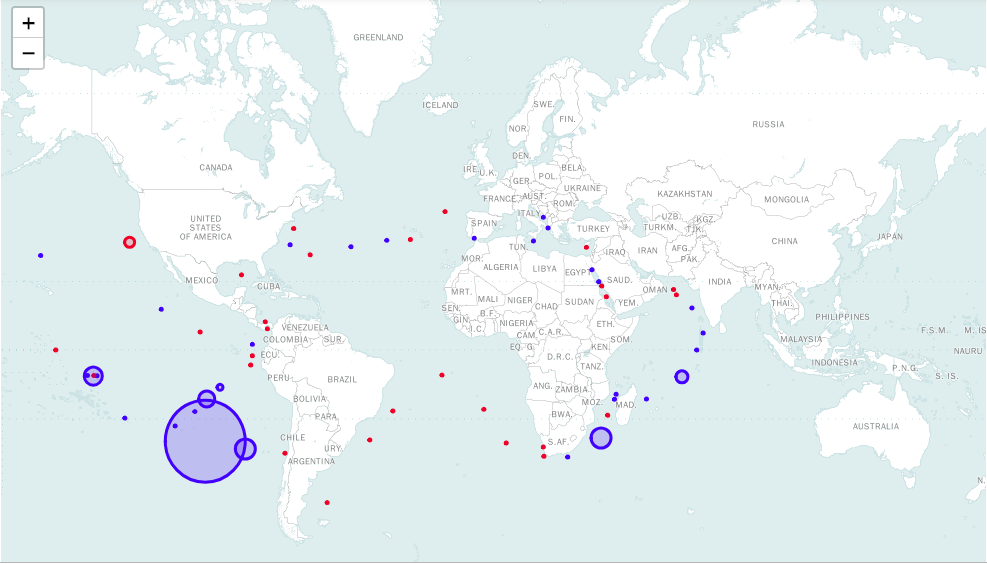

In [7]:
def map_differences(pred_train, pred_test, Abundance, sample_TARA, lat, lon, sampling_depth, colour='crimson', colour2='blue'):
    # concatenates all predicted abundance values from both testing and training
    # shuffles abundance values to randomize both compared values
    predicted_abundance = np.concatenate((pred_train, pred_test), axis=None)
    Abundance = shuffle(Abundance)

    data5 = pandas.DataFrame({
        'TARA': sample_TARA,
        'lat': lat,
        'lon': lon,
        'sampling_depth': sampling_depth,
        'abundance_difference': Abundance.values.flatten() - predicted_abundance})

    # create map and append circles for each location
    m, color = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2), colour
    for i in range(0, len(data5)):
        if float(data5.loc[i]['sampling_depth']) < 10:
            if float(data5.loc[i]['abundance_difference']) < 0:
                color = colour2
            folium.Circle(
                location=[data5.loc[i]['lat'], data5.loc[i]['lon']],
                radius=float(data5.loc[i]['abundance_difference']**2*0.12),
                color=color,
                fill=True,
                fill_color=color).add_to(m)
            color = colour

    return m


map_differences(pred_train, pred_test, Abundance, sample_TARA, lat, lon, sampling_depth)

#### More ML model practice.

This evaluates the difference in abundance between two samples collected. Then fits a regression model to predict the difference in abundance between two species. 
Plots the signed error (difference between predicted difference in sampling between the two species and the true abundance difference values between sample species). 
Only shows samples for which the depth is less than 10 meters for simplicity.

In [8]:
# 2 different samples: the original bacteria sampled and any other specimen in terms of abundance randomly chosen
# RandomForestRegressor fits its model with inputs of abundance of specimen 2 and OG bacterial abundance,
# evaluated output is the abundance difference between two specimen samples in each location, depth < 10
# tomato colour for overprediction, mediumslateblue for underprediction.
# radius ~ [difference between True & predicted (abundance difference) between 2 specimen samples]

# overall, the viewer can visually interpret the accuracy of the randomforest regressor based on radius size
# and adjust accordingly to their desire in terms of accuracy

def map_diff_comparison(abundance, other_abundance, sample_TARA, lat, lon, sampling_depth, max_depth=3):
    dump_data = pandas.DataFrame({'Abundance2': abundance, 'other_abundance2': other_abundance})
    learning_data = pandas.DataFrame({
        'other abundance': other_abundance,
        'abundance': abundance,
        'Actual_Difference': dump_data.Abundance2.values.flatten() - dump_data.other_abundance2.values.flatten()})

    # split data into input and output for regression model
    X2 = learning_data.drop(['Actual_Difference'], axis=1).values
    Y2 = learning_data['Actual_Difference'].values
    X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=67)
    
    # fit forest model, obtain predicted abundance difference values
    forest_model = RandomForestRegressor(n_estimators=100, max_depth=max_depth)
    forest_model.fit(X_train2, Y_train2)
    pred_train2 = forest_model.predict(X_train2)
    pred_test2 = forest_model.predict(X_test2)
    
    # maps the accuracy of the randomforest predicting the difference in abundance between two species
    return map_differences(pred_train2, pred_test2, learning_data.Actual_Difference, sample_TARA, lat, lon, sampling_depth,
                           'tomato', 'mediumslateblue')

# create all data, with another random specimen abundance value collected
sample_TARA, date, lat, lon, sampling_depth, size_fraction, abundance, all_lat, all_lon, other_abundance = read_input_data(
    r'.\sample_properties.txt', r'.\miTAG.taxonomic.profiles.release.txt', np.random.randint(low=1, high=156))

map_diff_comparison(abundance, other_abundance, sample_TARA, lat, lon, sampling_depth)
